In [1]:
import numpy as np


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from scipy.spatial import distance
from scipy.linalg import norm
from scipy.spatial.distance import euclidean
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
#token = IBMQ.save_account('24f9b17bb2ed402e361d6135ce47685773353c2456e773993f11cffbc7d378f47c760784f62935349429e848999e1029cc97eead6c183bd45a5bb1ce9c784628')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def all_error(circ, qubits):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error
    from qiskit.providers.ibmq.job import job_monitor
    from qiskit.providers.ibmq import least_busy
    
    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    all_err = NoiseModel()
    all_err.add_all_qubit_quantum_error(re_err,"reset")
    all_err.add_all_qubit_quantum_error(meas_err,"measure")
    all_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    all_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    
    
       # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        all_err.add_quantum_error(errors_reset[j], "reset", [j])
        all_err.add_quantum_error(errors_measure[j], "measure", [j])
        all_err.add_quantum_error(errors_u1[j], "u1", [j])
        all_err.add_quantum_error(errors_u2[j], "u2", [j])
        all_err.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            all_err.add_quantum_error(errors_cx[j][k], "cx", [j, k])
        
    
    
    p_gate = 0.1
    error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_depolar = NoiseModel()
    all_err.add_all_qubit_quantum_error(error_meas, "measure", qubits)
    
    
    provider = IBMQ.load_account()
    get_provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backends = provider.backends(simulator=False, operational=True)
    print(backends)
    C = ['ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila', 'ibm_nairobi', 'ibm_oslo']
    for i in range(len(list(backends))):
        
        
        backend = least_busy(backends)
        if(backend.configuration().n_qubits > 2):
            print(backend, end='\n')
            noise_model = NoiseModel.from_backend(backend)
            print(noise_model, end='\n')
            coupling_map = backend.configuration().coupling_map
            basis_gates = noise_model.basis_gates
            print(basis_gates, end='\n')
            noise_model = NoiseModel.from_backend(backend).to_dict()
            #noise_model = NoiseModel.from_backend(backend).to_dict()
            #real_hardware_run = transpile(circ, noise_model)
            #qobj = assemble(circ, backend=backend, shots=1024)
        # execute the circuit
            #job = backend.run(qobj)
            real_run = execute(circ, backend= backend, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result()
            #job = backend.run(real_run, shots= 1024)
            #print(real_run.job_id(), end='\n')
            #job_monitor(real_run)
            counts = real_run.get_counts()
            plot_bit= plot_histogram(counts)
            display(plot_bit)
            sim_noise = AerSimulator(noise_model=all_err)
    
            tnoise = transpile(circ, sim_noise)
            result_all_err = sim_noise.run(tnoise).result()
            counts_all_err = result_all_err.get_counts()
    
    
            legend = ['real_device', 'simulated_noise']
            plot_bit = plot_histogram([counts, counts_all_err], legend= legend)
            display(plot_bit)
    
    
            num_binary_states = 2**qubits

            # get the total counts for two dictionaries
            N1 = sum(counts.values())
            N2 = sum(counts_all_err.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
            for number in range(2**qubits):
            
            
            
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
                binary_state = '{0:b}'.format(number).zfill(qubits)

                if binary_state not in counts:
                    
        
                    counts[binary_state] = 0
        
                if binary_state not in counts_all_err:
                
                    counts_all_err[binary_state] = 0

    # following loop actually computes the TVD between two distributions
            tvd = 0
            print(' TVD Distribution')
            for key in counts:
                print(key)
                print(counts[key], counts_all_err[key])
                tvd = tvd + 0.5 * abs(counts[key]/N1 - counts_all_err[key]/N2)
                print(tvd)
    
    
            print('Jensen-Shannon Distance')
            from scipy.spatial import distance
            a = counts.values()
            b = counts_all_err.values()
            data_a = list(a)
            data_b = list(b)
            arr_a = np.array(data_a)
            arr_b = np.array(data_b)
            jsd = distance.jensenshannon(arr_a, arr_b)
            print(jsd)
    
            print('Hellinger Distance') 
            _SQRT2 = np.sqrt(2)
            hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
            print(hell1)
            hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
            print(hell2)
            hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
            print(hell3)
            backends.remove(backend)
    
    
    
    return plot_bit, tvd, jsd, hell1, hell2, hell3

In [2]:
#noise model for bit code circuit
# kernel is dying
# trying to opitimize the noise model so that kernel doenst dies
def all_error(circ, qubits):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error
    from qiskit.providers.ibmq.job import job_monitor
    from qiskit.providers.ibmq import least_busy
    
    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    all_err = NoiseModel()
    all_err.add_all_qubit_quantum_error(re_err,"reset")
    all_err.add_all_qubit_quantum_error(meas_err,"measure")
    all_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    all_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    
    
       # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    #noise_thermal = NoiseModel()
    for j in range(qubits):
        all_err.add_quantum_error(errors_reset[j], "reset", [j])
        all_err.add_quantum_error(errors_measure[j], "measure", [j])
        all_err.add_quantum_error(errors_u1[j], "u1", [j])
        all_err.add_quantum_error(errors_u2[j], "u2", [j])
        all_err.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            all_err.add_quantum_error(errors_cx[j][k], "cx", [j, k])
        
    
    
    p_gate = 0.1
    #error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    #noise_depolar = NoiseModel()
    #all_err.add_all_qubit_quantum_error(re_err, "measure", qubits)
    
    
    #provider = IBMQ.load_account()
    get_provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backends = provider.backends(simulator=False, operational=True)
    print(backends)
    C = ['ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila', 'ibm_nairobi', 'ibm_oslo']
    for i in range(len(list(backends))):
        
        
        backend = least_busy(backends)
        if(backend.configuration().n_qubits > 2):
            print(backend, end='\n')
            noise_model = NoiseModel.from_backend(backend)
            print(noise_model, end='\n')
            coupling_map = backend.configuration().coupling_map
            basis_gates = noise_model.basis_gates
            print(basis_gates, end='\n')
            noise_model = NoiseModel.from_backend(backend).to_dict()
            #noise_model = NoiseModel.from_backend(backend).to_dict()
            #real_hardware_run = transpile(circ, noise_model)
            #qobj = assemble(circ, backend=backend, shots=1024)
        # execute the circuit
            #job = backend.run(qobj)
            real_run = execute(circ, backend= backend, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result()
            #job = backend.run(real_run, shots= 1024)
            #print(real_run.job_id(), end='\n')
            #job_monitor(real_run)
            counts = real_run.get_counts()
            plot_bit= plot_histogram(counts)
            display(plot_bit)
            sim_noise = AerSimulator(noise_model=all_err)
    
            tnoise = transpile(circ, sim_noise)
            result_all_err = sim_noise.run(tnoise).result()
            counts_all_err = result_all_err.get_counts()
    
    
            legend = ['real_device', 'simulated_noise']
            plot_bit = plot_histogram([counts, counts_all_err], legend= legend)
            display(plot_bit)
    
    
            num_binary_states = 2**qubits

            # get the total counts for two dictionaries
            N1 = sum(counts.values())
            N2 = sum(counts_all_err.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
            for number in range(2**qubits):
            
            
            
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
                binary_state = '{0:b}'.format(number).zfill(qubits)

                if binary_state not in counts:
                    
        
                    counts[binary_state] = 0
        
                if binary_state not in counts_all_err:
                
                    counts_all_err[binary_state] = 0

    # following loop actually computes the TVD between two distributions
            tvd = 0
            print(' TVD Distribution')
            for key in counts:
                print(key)
                print(counts[key], counts_all_err[key])
                tvd = tvd + 0.5 * abs(counts[key]/N1 - counts_all_err[key]/N2)
                print(tvd)
    
    
            print('Jensen-Shannon Distance')
            from scipy.spatial import distance
            a = counts.values()
            b = counts_all_err.values()
            data_a = list(a)
            data_b = list(b)
            arr_a = np.array(data_a)
            arr_b = np.array(data_b)
            jsd = distance.jensenshannon(arr_a, arr_b)
            print(jsd)
    
            print('Hellinger Distance') 
            _SQRT2 = np.sqrt(2)
            hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
            print(hell1)
            hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
            print(hell2)
            hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
            print(hell3)
            backends.remove(backend)
    
    
    
    return plot_bit, tvd, jsd, hell1, hell2, hell3

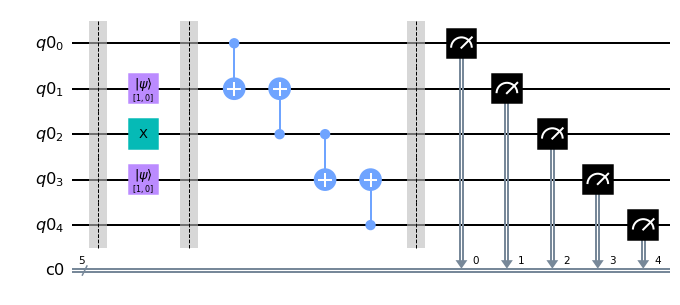

In [3]:
#bit code
bit_q  = QuantumRegister(5)
bit_c = ClassicalRegister(5)
bit_circ = QuantumCircuit(bit_q,bit_c)
bit_circ.barrier()
bit_circ.initialize([1,0], 1)
bit_circ.x(bit_q[2])
bit_circ.initialize([1,0], 3)
bit_circ.barrier()
bit_circ.cx(bit_q[0], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[3])
bit_circ.cx(bit_q[4], bit_q[3])
bit_circ.barrier()
bit_circ.measure(bit_q[0:5],bit_c[0:5])
display(bit_circ.draw())


In [ ]:
all_error(bit_circ, len(bit_q))

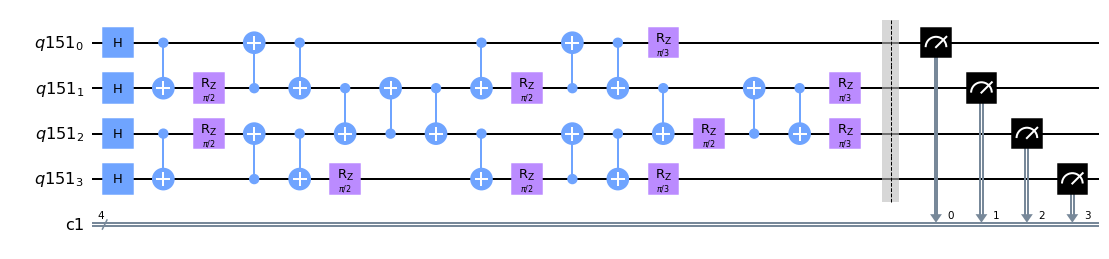

In [5]:
swap_qaoa_q = QuantumRegister(4)
swap_qaoa_c = ClassicalRegister(4)
swap_qaoa_circ = QuantumCircuit(swap_qaoa_q, swap_qaoa_c)
swap_qaoa_circ.h(swap_qaoa_q[0:4])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/3, 0)
swap_qaoa_circ.rz(np.pi/3, 1)
swap_qaoa_circ.rz(np.pi/3, 2)
swap_qaoa_circ.rz(np.pi/3, 3)
swap_qaoa_circ.barrier()
swap_qaoa_circ.measure(swap_qaoa_q[0:4], swap_qaoa_c[0:4])
display(swap_qaoa_circ.draw())

ibmqfactory.load_account:WARNING:2022-07-10 07:16:23,784: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibm_oslo
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx',

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


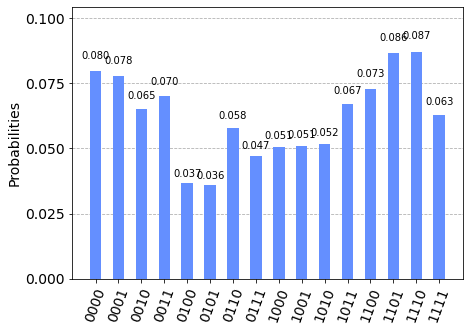

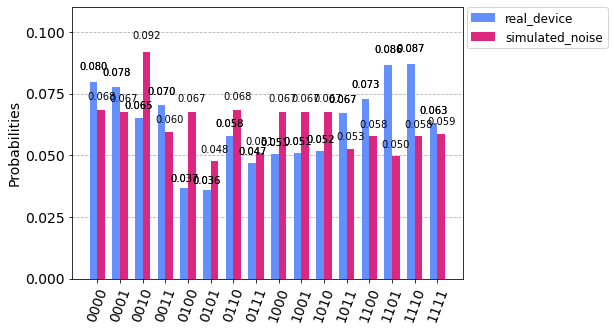

 TVD Distribution
0000
319 70
0.005695312500000001
0001
311 69
0.01087890625
0010
260 94
0.02427734375
0011
281 61
0.029617187500000003
0100
147 69
0.04493359375
0101
144 49
0.050859375
0110
231 70
0.0561640625
0111
188 52
0.0580546875
1000
202 69
0.06649609375
1001
204 69
0.0746875
1010
207 69
0.08250390625000001
1011
268 54
0.08963671875000001
1100
292 59
0.09732812500000002
1101
346 51
0.11567578125000001
1110
348 59
0.1303671875
1111
252 60
0.1325703125
Jensen-Shannon Distance
0.08322423585493385
Hellinger Distance
22.410275533412626
22.410275533412626
22.41027553341263
ibmq_lima


/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn(

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
['cx', 'id', 'reset', 'rz', 'sx', 'x']


/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn(

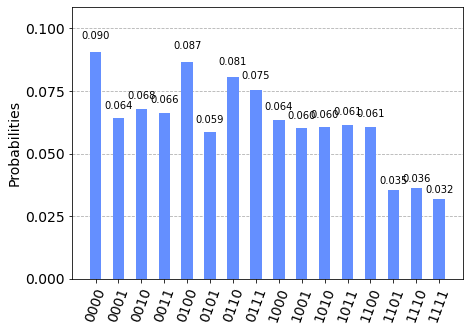

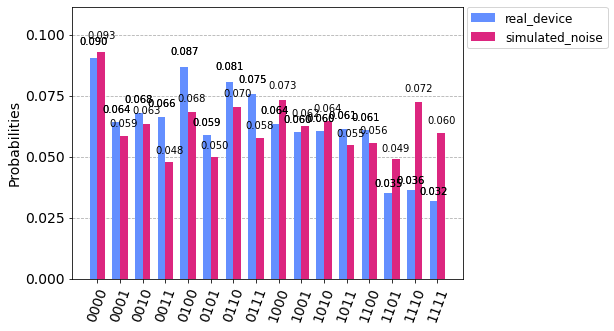

 TVD Distribution
0000
362 95
0.0011367187500000014
0001
256 60
0.003839843750000002
0010
271 65
0.0059765625000000044
0011
265 49
0.015175781250000006
0100
347 70
0.024371093750000003
0101
235 51
0.02884375
0110
323 72
0.0340625
0111
302 59
0.04300390625
1000
254 75
0.047875
1001
240 64
0.049125
1010
242 66
0.0511015625
1011
246 56
0.0545078125
1100
243 57
0.05705078125
1101
141 50
0.06383984375
1110
145 74
0.08184765625
1111
128 61
0.0956328125
Jensen-Shannon Distance
0.11491132140962546
Hellinger Distance
22.696704534549763
22.696704534549763
22.69670453454977
ibmq_belem
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3))

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


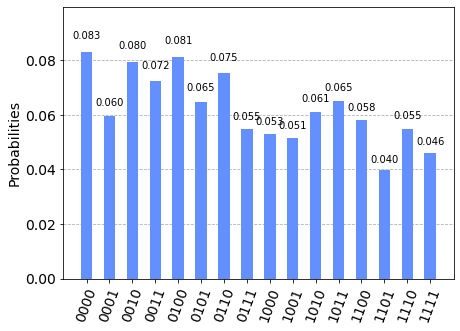

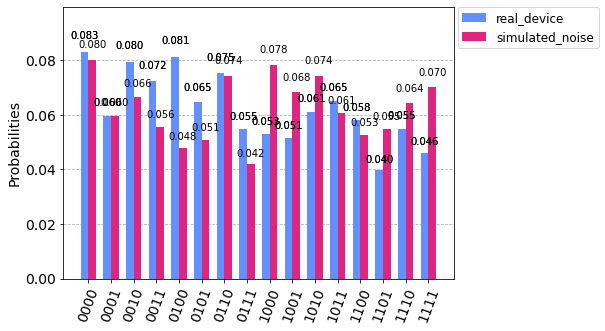

 TVD Distribution
0000
332 82
0.0014609375000000022
0001
239 61
0.001550781250000001
0010
318 68
0.008097656250000002
0011
290 57
0.016515625
0100
325 49
0.03321484375
0101
259 52
0.04019921875
0110
301 76
0.04071484375
0111
219 43
0.047093750000000004
1000
212 80
0.05965625000000001
1001
206 70
0.06808593750000001
1010
244 76
0.07469531250000001
1011
260 62
0.07692187500000001
1100
232 54
0.07955468750000001
1101
159 56
0.08702343750000001
1110
220 66
0.09175000000000001
1111
184 72
0.10390625
Jensen-Shannon Distance
0.08612147430552196
Hellinger Distance
22.432088186637813
22.432088186637813
22.432088186637813
ibm_nairobi
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


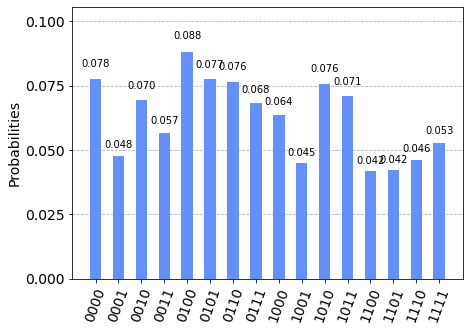

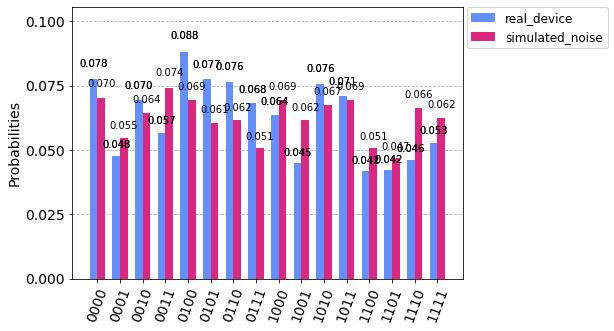

 TVD Distribution
0000
311 72
0.00371875
0001
191 56
0.0071874999999999994
0010
278 66
0.009710937500000003
0011
227 76
0.0184453125
0100
352 71
0.02777734375
0101
310 62
0.036253906249999995
0110
306 63
0.043742187499999995
0111
273 52
0.0524765625
1000
254 71
0.05539453125
1001
179 63
0.06378125
1010
303 69
0.06796484375
1011
284 71
0.06879687500000001
1100
167 52
0.0733125
1101
169 48
0.075625
1110
185 68
0.08570312499999999
1111
211 64
0.090578125
Jensen-Shannon Distance
0.09525775642572056
Hellinger Distance
22.506770124157036
22.506770124157036
22.506770124157036
ibmq_quito
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


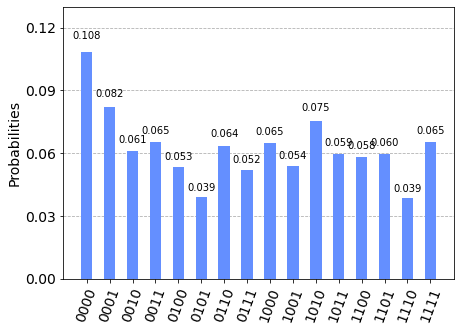

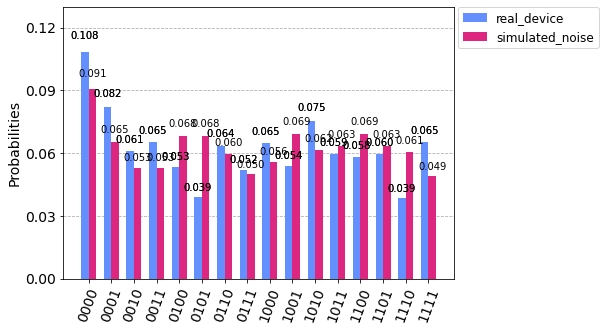

 TVD Distribution
0000
433 93
0.00871484375
0001
328 67
0.017
0010
244 54
0.0211328125
0011
261 54
0.027390625000000002
0100
213 70
0.034945312500000006
0101
157 70
0.0495
0110
254 61
0.05146484375
0111
208 51
0.0525625
1000
259 57
0.05710546875
1001
215 71
0.0648984375
1010
302 63
0.07188671875
1011
238 65
0.073875
1100
233 71
0.07941796875
1101
239 65
0.08128125
1110
155 62
0.0921796875
1111
261 50
0.100390625
Jensen-Shannon Distance
0.09948576319264579
Hellinger Distance
22.544474542182986
22.544474542182986
22.544474542182982
ibmq_manila
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)),

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


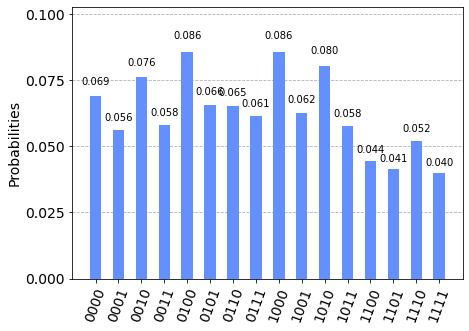

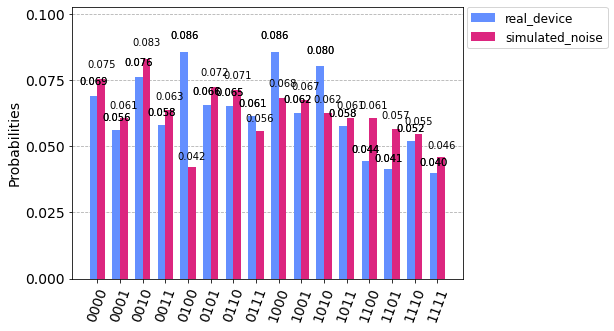

 TVD Distribution
0000
276 77
0.003097656249999997
0001
224 62
0.0053710937499999965
0010
304 85
0.008874999999999997
0011
232 65
0.011613281249999996
0100
342 43
0.0333671875
0101
262 74
0.03675
0110
261 73
0.03976953125
0111
245 57
0.042562499999999996
1000
342 70
0.0511328125
1001
250 69
0.05357421875
1010
321 64
0.06244921875
1011
230 62
0.06397265625
1100
178 62
0.07199609374999999
1101
165 58
0.07969140624999999
1110
208 56
0.08103515624999999
1111
160 47
0.08398437499999999
Jensen-Shannon Distance
0.1047438729431356
Hellinger Distance
22.59245770196668
22.59245770196668
22.59245770196668


(<Figure size 504x360 with 1 Axes>,
 0.08398437499999999,
 0.1047438729431356,
 22.59245770196668,
 22.59245770196668,
 22.59245770196668)

In [7]:
all_error(swap_qaoa_circ, len(swap_qaoa_q))

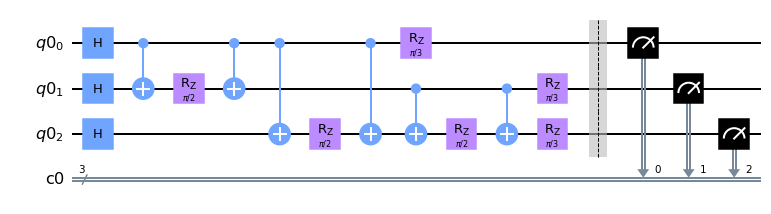

In [3]:
vanilla_qaoa_q = QuantumRegister(3)
vanilla_qaoa_c = ClassicalRegister(3)
vanilla_qaoa_circ = QuantumCircuit(vanilla_qaoa_q, vanilla_qaoa_c)
vanilla_qaoa_circ.h(vanilla_qaoa_q[0:3])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.rz(np.pi/2, 1)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/3, 0)
vanilla_qaoa_circ.rz(np.pi/3, 1)
vanilla_qaoa_circ.rz(np.pi/3, 2)
vanilla_qaoa_circ.barrier()
vanilla_qaoa_circ.measure(vanilla_qaoa_q[0:3], vanilla_qaoa_c[0:3])
display(vanilla_qaoa_circ.draw())

[<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibmq_lima


/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn(

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
['cx', 'id', 'reset', 'rz', 'sx', 'x']


/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn(

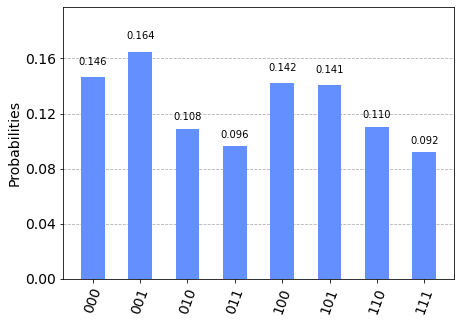

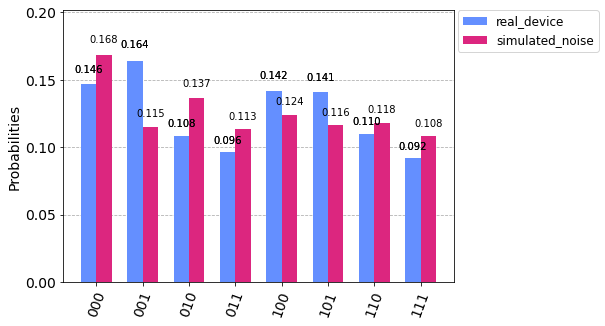

 TVD Distribution
000
586 172
0.010734375000000004
001
657 118
0.03524218750000001
010
434 140
0.04935156250000001
011
385 116
0.05786718750000001
100
568 127
0.06685546875000001
101
563 119
0.079125
110
440 121
0.08320703125000001
111
367 111
0.09153125000000001
Jensen-Shannon Distance
0.06784543247746572
Hellinger Distance
22.30397514834186
22.30397514834186
22.30397514834186
ibm_oslo
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (5, 3)), ('cx', (3, 5)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (4, 5)), ('cx'

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


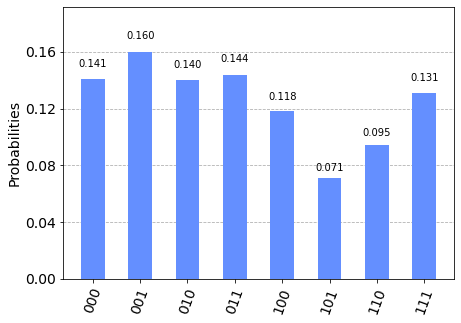

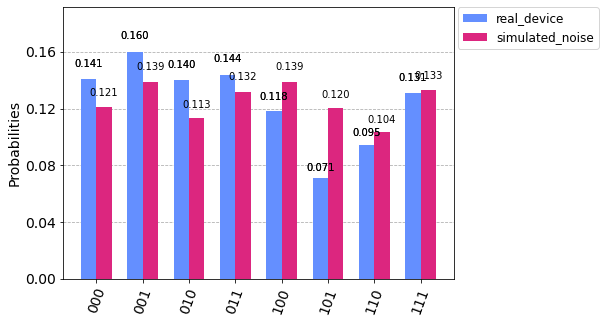

 TVD Distribution
000
564 124
0.009953124999999993
001
638 142
0.020367187499999995
010
560 116
0.0337265625
011
576 135
0.039808593749999996
100
474 142
0.04989453125
101
285 123
0.074328125
110
378 106
0.0788359375
111
525 136
0.07961718749999999
Jensen-Shannon Distance
0.09394633420845792
Hellinger Distance
22.495963497779346
22.495963497779346
22.495963497779346
ibmq_belem
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


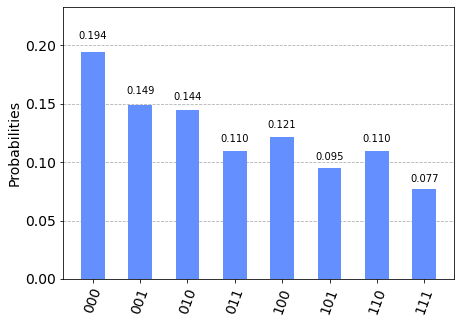

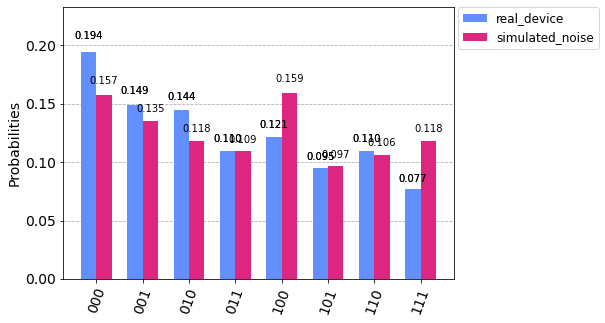

 TVD Distribution
000
775 161
0.018261718750000003
001
597 138
0.02550390625
010
577 121
0.038546874999999994
011
439 112
0.038734374999999995
100
485 163
0.057699218749999996
101
380 99
0.058539062499999996
110
439 109
0.060191406249999996
111
308 121
0.08077343749999999
Jensen-Shannon Distance
0.12092922349352854
Hellinger Distance
22.75633070777671
22.75633070777671
22.75633070777671
ibm_nairobi
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (5, 4)), ('cx', (4, 5)), ('cx', (5, 3)), ('cx', (3, 5)), ('cx', (1

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


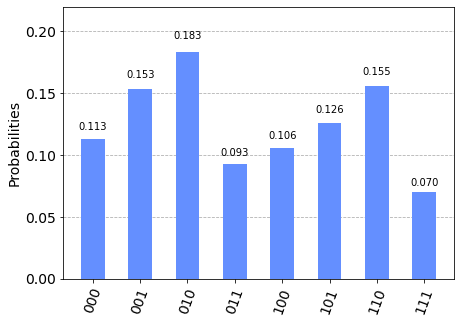

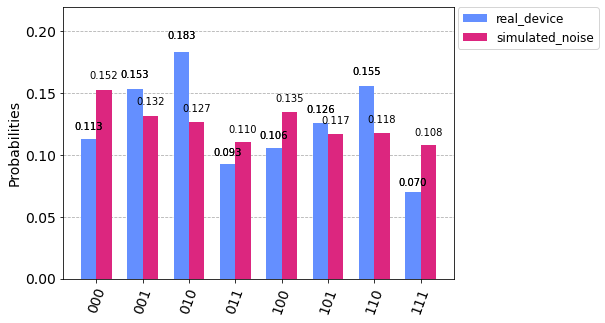

 TVD Distribution
000
452 156
0.019671875
001
613 135
0.030378906249999997
010
731 130
0.058277343749999995
011
372 113
0.066953125
100
424 138
0.08133593750000001
101
505 120
0.08586718750000001
110
622 121
0.10453515625000001
111
281 111
0.12360937500000001
Jensen-Shannon Distance
0.09032020304292797
Hellinger Distance
22.465597228720046
22.465597228720046
22.465597228720043
ibmq_quito
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset'

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


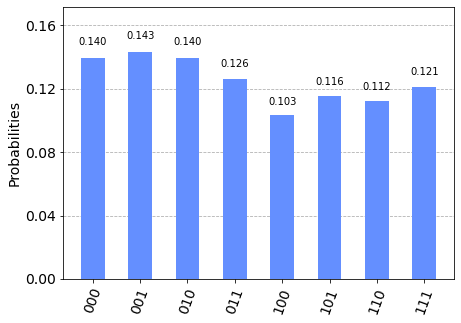

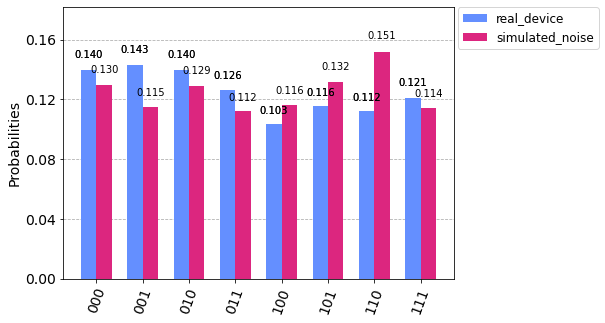

 TVD Distribution
000
558 133
0.0048085937500000064
001
571 118
0.01856640625
010
558 132
0.023863281250000007
011
504 115
0.030710937500000007
100
414 119
0.03706640625000001
101
462 135
0.04523437500000001
110
448 155
0.06491796875
111
485 117
0.0684140625
Jensen-Shannon Distance
0.03394194851920297
Hellinger Distance
22.14666762649268
22.14666762649268
22.14666762649268
ibmq_manila
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


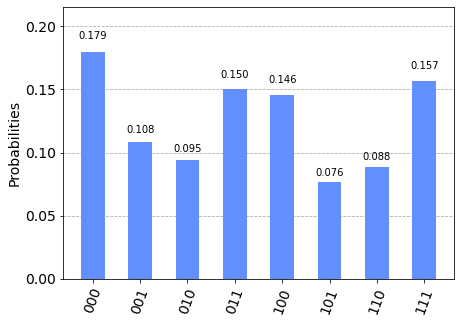

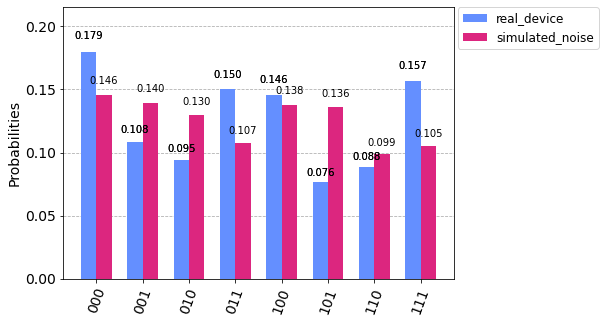

 TVD Distribution
000
717 149
0.016871093749999996
001
434 143
0.0324453125
010
378 133
0.050136718749999996
011
601 110
0.07155078125
100
584 141
0.075703125
101
306 139
0.10532421875
110
354 101
0.110390625
111
626 108
0.13590625
Jensen-Shannon Distance
0.11050846678724596
Hellinger Distance
22.64915059836654
22.64915059836654
22.64915059836654


(<Figure size 504x360 with 1 Axes>,
 0.13590625,
 0.11050846678724596,
 22.64915059836654,
 22.64915059836654,
 22.64915059836654)

In [4]:
all_error(vanilla_qaoa_circ, len(vanilla_qaoa_q))

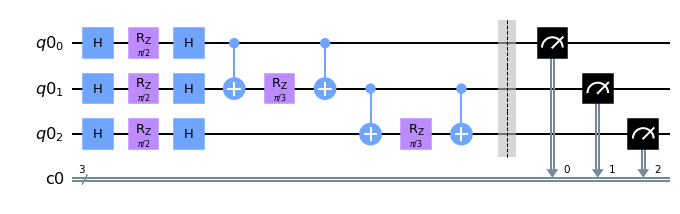

In [3]:
hamilton_q = QuantumRegister(3)
hamilton_c = ClassicalRegister(3)
hamilton_circ = QuantumCircuit(hamilton_q, hamilton_c)
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.rz(np.pi/2, hamilton_q[0:4])
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.rz(np.pi/3, 1)
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.rz(np.pi/3, 2)
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.barrier()
hamilton_circ.measure(hamilton_q[0:3], hamilton_c[0:3])
display(hamilton_circ.draw())

ibmqfactory.load_account:WARNING:2022-07-10 08:58:35,590: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibmq_lima


/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn(

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
['cx', 'id', 'reset', 'rz', 'sx', 'x']


/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn(

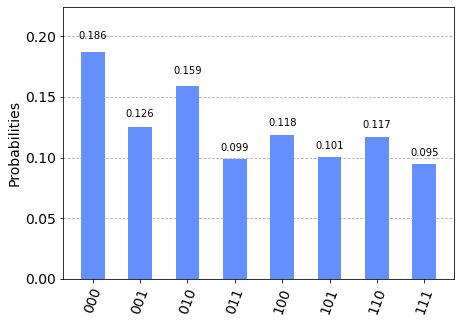

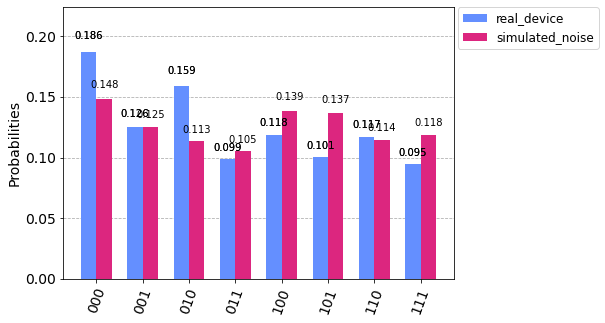

 TVD Distribution
000
746 152
0.01903125
001
502 128
0.01928125
010
636 116
0.042140625
011
394 108
0.045625
100
473 142
0.0558359375
101
403 140
0.0738203125
110
468 117
0.07519140625000001
111
378 121
0.08702343750000001
Jensen-Shannon Distance
0.06753708359392023
Hellinger Distance
22.302133459565727
22.302133459565727
22.302133459565727
ibm_oslo
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (4, 5)), ('cx', (5, 4)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (5, 3)), ('cx', (3, 5)), ('cx', (6, 5)), ('cx', (5, 

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


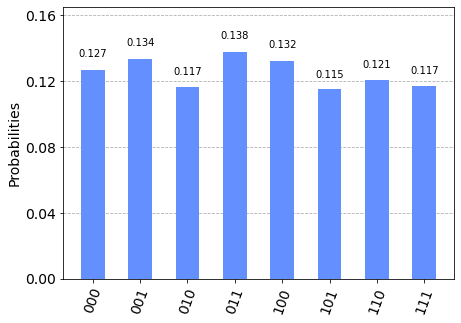

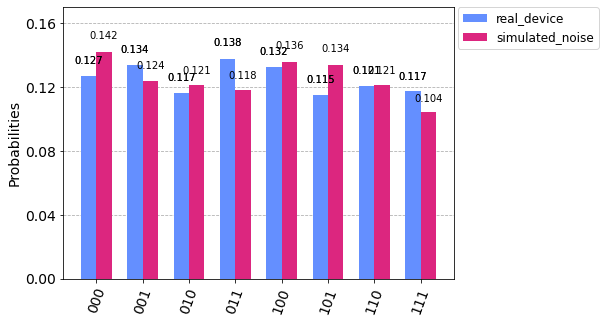

 TVD Distribution
000
508 145
0.007300781249999999
001
534 127
0.012039062500000003
010
466 124
0.0143359375
011
550 121
0.024003906250000005
100
529 139
0.025750000000000002
101
461 137
0.03501953125
110
483 124
0.03519140625
111
469 107
0.0415703125
Jensen-Shannon Distance
0.04191437466632465
Hellinger Distance
22.174304232064415
22.174304232064415
22.174304232064415
ibm_nairobi
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (5, 4)), ('cx', (4, 5)), ('cx', (5, 3)), ('cx', (3, 5)), ('cx', (1, 3)), ('cx', (3, 

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


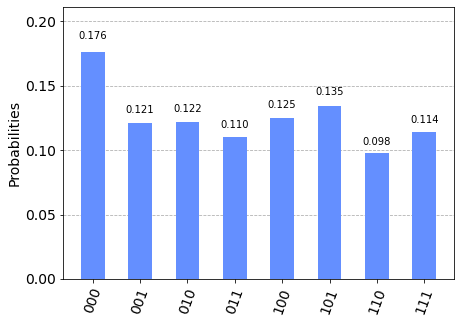

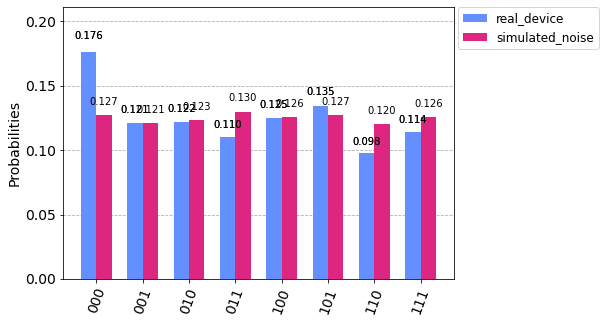

 TVD Distribution
000
703 130
0.024398437499999995
001
485 124
0.024476562499999993
010
488 126
0.024999999999999994
011
440 133
0.034941406249999994
100
501 129
0.035304687499999994
101
538 130
0.039078125
110
390 123
0.05038671875
111
455 129
0.056499999999999995
Jensen-Shannon Distance
0.06010483439651963
Hellinger Distance
22.259105379687348
22.259105379687348
22.259105379687348
ibmq_belem
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


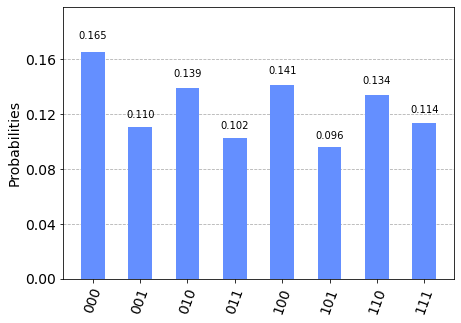

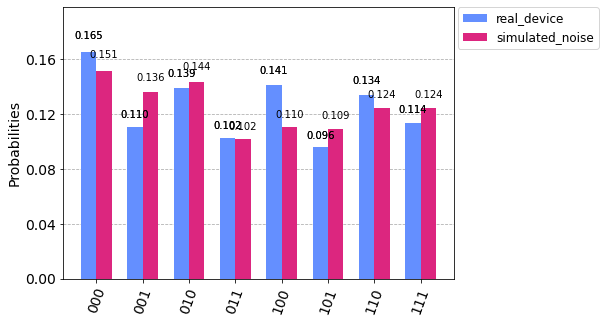

 TVD Distribution
000
659 155
0.006691406250000004
001
441 139
0.019437500000000003
010
555 147
0.021839843749999997
011
409 104
0.022183593749999994
100
563 113
0.03738281249999999
101
383 112
0.044195312499999986
110
536 127
0.04918359374999999
111
454 127
0.05444531249999999
Jensen-Shannon Distance
0.07899681679957575
Hellinger Distance
22.3784964795681
22.3784964795681
22.3784964795681
ibmq_quito
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


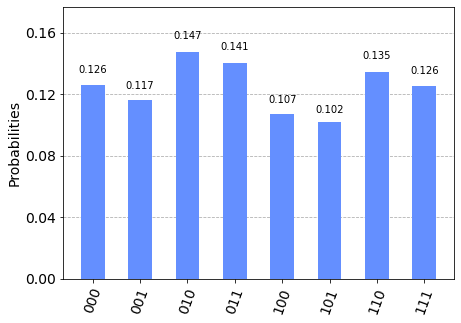

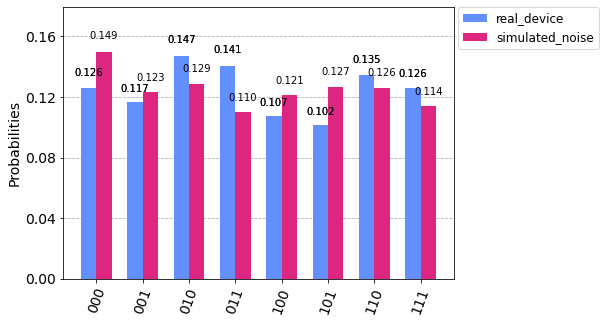

 TVD Distribution
000
504 153
0.01170703125
001
466 126
0.014980468749999996
010
589 132
0.024152343749999992
011
562 113
0.0392265625
100
430 124
0.0460234375
101
407 130
0.058625000000000003
110
539 129
0.06301171875
111
503 117
0.0687578125
Jensen-Shannon Distance
0.06449077022808089
Hellinger Distance
22.28398347795916
22.28398347795916
22.28398347795916
ibmq_manila
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'id', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


In [ ]:
all_error(hamilton_circ, len(hamilton_q))

In [4]:
# this cell is only to run hamiltonian simulation circuit on ibm_manila
def all_error(circ, qubits):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error
    from qiskit.providers.ibmq.job import job_monitor
    from qiskit.providers.ibmq import least_busy
    
    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    all_err = NoiseModel()
    all_err.add_all_qubit_quantum_error(re_err,"reset")
    all_err.add_all_qubit_quantum_error(meas_err,"measure")
    all_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    all_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    
    
       # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        all_err.add_quantum_error(errors_reset[j], "reset", [j])
        all_err.add_quantum_error(errors_measure[j], "measure", [j])
        all_err.add_quantum_error(errors_u1[j], "u1", [j])
        all_err.add_quantum_error(errors_u2[j], "u2", [j])
        all_err.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            all_err.add_quantum_error(errors_cx[j][k], "cx", [j, k])
        
    
    
    p_gate = 0.1
    error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_depolar = NoiseModel()
    all_err.add_all_qubit_quantum_error(error_meas, "measure", qubits)
    
    
    provider = IBMQ.load_account()
    get_provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backends = provider.backends(simulator=False, operational=True)
    print(backends)
    C = ['ibmq_manila']
    for i in range(len(C)):
        
        
        backend = provider.get_backend(C[i])
        if(backend.configuration().n_qubits > 2):
            print(backend, end='\n')
            noise_model = NoiseModel.from_backend(backend)
            print(noise_model, end='\n')
            coupling_map = backend.configuration().coupling_map
            basis_gates = noise_model.basis_gates
            print(basis_gates, end='\n')
            noise_model = NoiseModel.from_backend(backend).to_dict()
            #noise_model = NoiseModel.from_backend(backend).to_dict()
            #real_hardware_run = transpile(circ, noise_model)
            #qobj = assemble(circ, backend=backend, shots=1024)
        # execute the circuit
            #job = backend.run(qobj)
            real_run = execute(circ, backend= backend, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result()
            #job = backend.run(real_run, shots= 1024)
            #print(real_run.job_id(), end='\n')
            #job_monitor(real_run)
            counts = real_run.get_counts()
            plot_bit= plot_histogram(counts)
            display(plot_bit)
            sim_noise = AerSimulator(noise_model=all_err)
    
            tnoise = transpile(circ, sim_noise)
            result_all_err = sim_noise.run(tnoise).result()
            counts_all_err = result_all_err.get_counts()
    
    
            legend = ['real_device', 'simulated_noise']
            plot_bit = plot_histogram([counts, counts_all_err], legend= legend)
            display(plot_bit)
    
    
            num_binary_states = 2**qubits

            # get the total counts for two dictionaries
            N1 = sum(counts.values())
            N2 = sum(counts_all_err.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
            for number in range(2**qubits):
            
            
            
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
                binary_state = '{0:b}'.format(number).zfill(qubits)

                if binary_state not in counts:
                    
        
                    counts[binary_state] = 0
        
                if binary_state not in counts_all_err:
                
                    counts_all_err[binary_state] = 0

    # following loop actually computes the TVD between two distributions
            tvd = 0
            print(' TVD Distribution')
            for key in counts:
                print(key)
                print(counts[key], counts_all_err[key])
                tvd = tvd + 0.5 * abs(counts[key]/N1 - counts_all_err[key]/N2)
                print(tvd)
    
    
            print('Jensen-Shannon Distance')
            from scipy.spatial import distance
            a = counts.values()
            b = counts_all_err.values()
            data_a = list(a)
            data_b = list(b)
            arr_a = np.array(data_a)
            arr_b = np.array(data_b)
            jsd = distance.jensenshannon(arr_a, arr_b)
            print(jsd)
    
            print('Hellinger Distance') 
            _SQRT2 = np.sqrt(2)
            hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
            print(hell1)
            hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
            print(hell2)
            hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
            print(hell3)
            backends.remove(backend)
    
    
    
    return plot_bit, tvd, jsd, hell1, hell2, hell3

In [ ]:
all_error(hamilton_circ, len(hamilton_q))

[<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibmq_manila
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'sx', 'measure', 'reset', 'id', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 

/opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)
